# Precio de terrenos por fracción censal

En este notebook se exploran datasets con datos sobre precios de terrenos en la CABA. Los datos anuales son muy pocos como para garantizar la estabilidad del resultado (menos de 2000 por año) y una cobertura adecuada de la ciudad. 

Después de explorar algunas opciones como la actualización de datos de otros años a un año base (por ejemplo 2010) para mejorar la cobertura, se creó un indicador pero se lo consideró no suficientemente representativo como para utilizarlo en el frontend abierto al público. De todas maneras, se mantiene este notebook en el repositorio para referencia metodológica futura.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
from scripts.land_prices import get_data, remove_scarce_data
from scripts.land_prices import intersect_data_with_shps
from scripts.path_finders import get_division_path, get_data_dir, get_indicators_path

## Cargar los datos disponibles

Se construye un único dataframe con los datos disponibles de precios de terrenos desde el 2001. Se corrigen los nombres de algunos barrios que siguen más de una convención posible.

In [2]:
replacements = {"MONTSERRAT": "MONSERRAT", 
                "NUÑEZ".decode("utf-8"): "NUNEZ",
                "PARQUE AVELLANEDA": "PARQUE AVELLANED", 
                "VILLA GRAL. MITRE": ["VILLA GRAL MITRE", "VILLA GRAL. MITR"]}

In [3]:
df_completo = get_data(years=range(2001, 2015), replacements=replacements, recalculate=False)
df_completo.head()

,BARRIO,CALLE,COMUNA,DOLARES,YEAR,FECHA,LAT,LON,M2,NUMERO,U_S_M2,CO_FRACC,CO_FRAC_RA
0,PARQUE CHACABUCO,ZUVIRIA,7,170000,2014,2015/02/19,-34.629206,-58.433503,108,500,1574.1,007_22,7_22_8
1,CABALLITO,CUCHA CUCHA,6,268000,2014,2015/02/19,-34.611803,-58.448462,250,900,1072.0,006_4,6_4_2
2,VILLA LURO,CORTINA,10,550000,2014,2015/02/20,-34.634621,-58.505294,340,400,1617.6,010_8,10_8_9
3,MONTE CASTRO,CORTINA,10,215000,2014,2015/02/18,-34.625079,-58.518445,160,1700,1343.8,010_5,10_5_13
4,VILLA REAL,CORTINA,10,144000,2014,NaN,-34.619698,-58.525691,100,2400,1440.0,010_1,10_1_7


## Cálculo de un promedio por fracción censal

El año 2014 es el que más cantidad de datos tiene.

In [4]:
df_completo.groupby("YEAR").count()

,BARRIO,CALLE,COMUNA,DOLARES,FECHA,LAT,LON,M2,NUMERO,U_S_M2,CO_FRACC,CO_FRAC_RA
YEAR,,,,,,,,,,,,
2001,1342,1342,1342,1342,1342,1342,1342,1342,1342,1342,1342,1342
2002,368,368,368,368,368,368,368,368,368,368,368,368
2003,569,569,569,569,558,569,569,569,569,569,569,569
2004,1211,1213,1212,1213,1213,1213,1213,1213,1213,1213,1211,1211
2005,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036
2006,1241,1241,1241,1241,1241,1241,1241,1241,1241,1241,1240,1240
2007,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707
2008,889,889,889,889,889,889,889,889,889,889,889,889
2009,1455,1455,1455,1455,960,1455,1455,1455,1455,1455,1455,1455


No se utilizarán datos anteriores a 2006.

In [5]:
df = df_completo[df_completo["YEAR"] > 2005]

Se calculan los precios promedio de los terrenos para distintos niveles de agregación.

In [6]:
def calc_average_usd_m2(df, pivot_unit=None, date_unit="YEAR"):
    if pivot_unit:
        value = pd.pivot_table(df, values='DOLARES', index=[pivot_unit], columns=[date_unit], aggfunc=np.sum)
        m2 = pd.pivot_table(df, values='M2', index=[pivot_unit], columns=[date_unit], aggfunc=np.sum)
    else:
        value = pd.pivot_table(df, values='DOLARES', columns=[date_unit], aggfunc=np.sum)
        m2 = pd.pivot_table(df, values='M2', columns=[date_unit], aggfunc=np.sum)
    return value / m2

In [7]:
comunas = calc_average_usd_m2(df, "COMUNA")
barrios = calc_average_usd_m2(df, "BARRIO")
fracciones = calc_average_usd_m2(df, "CO_FRACC")
caba = calc_average_usd_m2(df)

Eliminamos los promedios realizados con pocos datos. El número indica el mínimo de datos exigido para calcular cada promedio.

In [8]:
remove_scarce_data(comunas, df, "COMUNA", 10)
remove_scarce_data(barrios, df, "BARRIO", 5)
remove_scarce_data(fracciones, df, "CO_FRACC", 3)

COMUNA start with  120 values
COMUNA end with 118 values 

BARRIO start with  373 values
BARRIO end with 346 values 

CO_FRACC start with  2204 values
CO_FRACC end with 1434 values 



Cantidad de unidades ofertadas por precio del m2.

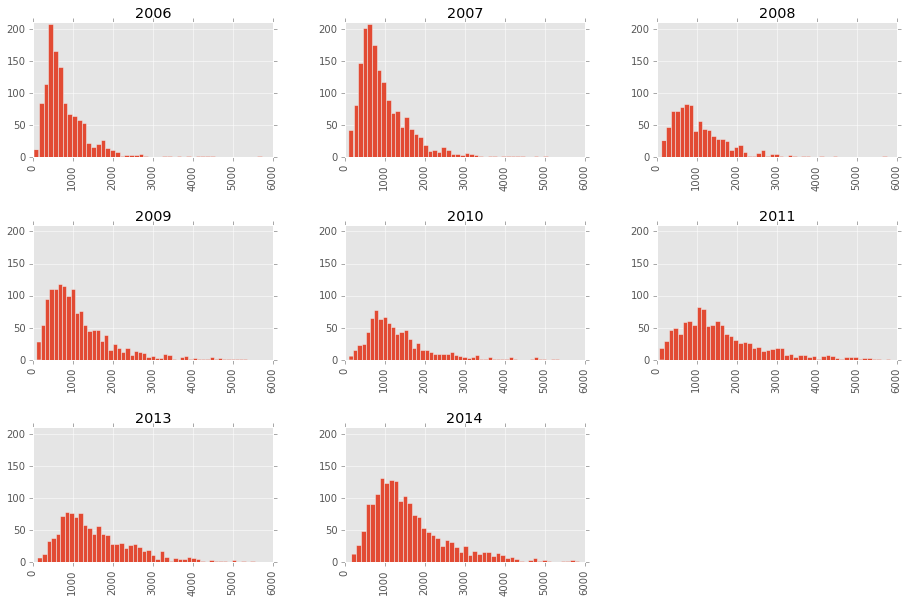

In [9]:
hists = df["U_S_M2"][df["U_S_M2"] < 6000].hist(by=df["YEAR"], bins=50, figsize=(15, 10))
hists = [hist.set_ylim((0, 210)) for row in hists for hist in row]

Precio promedio en la caba del m2 de terreno ofertado.

In [10]:
caba

YEAR
2006     968.110544
2007     976.008934
2008    1090.986450
2009     963.594884
2010    1239.332564
2011    1303.560424
2013    1642.565605
2014    1583.043292
dtype: float64

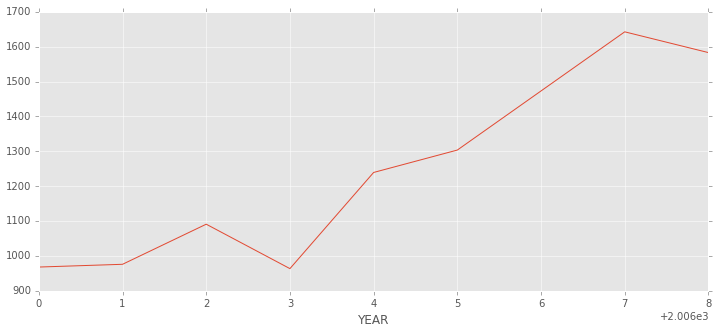

In [11]:
caba.plot(kind="line", figsize=(12, 5))

## Análisis de la posibilidad de actualizar datos de otros años

Testeamos la posibilidad de actualizar los precios por índices a partir del promedio de barrios o comunas, en aquellos casos donde la pérdida de variabilidad entre fracciones dentro del mismo barrio o comuna no parezca demasiado grave.

In [12]:
var_comuna = comunas.transpose().pct_change()
var_barrio = barrios.transpose().pct_change()
var_fracc = fracciones.transpose().pct_change()
var_barrio

BARRIO,AGRONOMIA,ALMAGRO,BALVANERA,BARRACAS,BELGRANO,BOCA,BOEDO,CABALLITO,CHACARITA,COGHLAN,...,VILLA GRAL. MITRE,VILLA LUGANO,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA
YEAR,,,,,,,,,,,,,,,,,,,,,
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,0.397675,0.083704,0.117623,0.511214,0.166136,-0.108624,0.184553,0.422800,0.250802,-0.088308,...,-0.078325,1.645802,0.032167,-0.015318,-0.033142,-0.051134,0.478956,-0.130968,NaN,0.044493
2008,0.267670,0.165592,0.660736,1.577543,-0.044664,0.634175,-0.141599,-0.041607,0.297358,0.215336,...,1.056184,0.381845,1.244619,0.175026,0.321132,NaN,NaN,-0.084012,NaN,0.056554
2009,-0.344707,-0.155409,-0.439074,-0.474834,-0.132134,0.180430,-0.284028,0.021106,-0.250730,-0.099466,...,-0.490249,0.072583,-0.422538,-0.233311,-0.122063,NaN,NaN,0.593822,NaN,-0.042757
2010,0.333620,0.557764,0.781586,0.019018,0.567729,0.023731,0.748596,0.241701,0.160324,0.027023,...,0.537032,NaN,0.490439,1.390584,0.351387,NaN,NaN,0.093649,NaN,-0.049068
2011,-0.006760,0.448182,-0.068476,-0.005512,-0.362477,-0.232949,-0.086557,0.318964,0.336426,-0.046498,...,-0.341811,0.187735,0.115649,-0.251727,0.422208,3.919973,NaN,0.382433,NaN,0.845459
2013,-0.002789,-0.138715,0.592999,0.590933,0.632586,1.221061,0.379511,-0.135366,0.205028,0.191009,...,1.242999,NaN,0.001048,-0.060519,-0.151541,-0.627639,0.172021,-0.018786,NaN,-0.203511
2014,-0.027166,-0.279303,-0.016105,0.132701,0.380122,-0.108693,0.031894,-0.045239,-0.318563,0.613298,...,-0.146527,0.585979,0.191075,0.425658,0.095066,-0.252578,NaN,0.114527,NaN,0.048805


Creamos un data frame con las variaciones por fracción censal y período, para testear modelos que predigan estas variaciones con el promedio barrial o comunal.

In [13]:
df_vars = pd.DataFrame(columns=["CO_FRACC", "periodo", "var_fracc", 
                                "COMUNA", "var_comuna", "BARRIO", "var_barrio"]).set_index(["CO_FRACC", "periodo"])
df_vars

,,var_fracc,COMUNA,var_comuna,BARRIO,var_barrio
CO_FRACC,periodo,,,,,


In [14]:
def populate_with_vars(df_vars, var_fracc, var_comuna, var_barrio, df_divs):
    for row in var_fracc.iterrows():
        period = row[0]
        for fracc in var_fracc.columns:
            value = row[1][fracc]
            
            if pd.notnull(value):
                comuna = df_divs[df_divs["CO_FRACC"] == fracc]["COMUNA"].iloc[0]
                barrio = df_divs[df_divs["CO_FRACC"] == fracc]["BARRIO"].iloc[0]
                df_vars.ix[(fracc, period), :] = [value, comuna, var_comuna[comuna][period], 
                                                  barrio, var_barrio[barrio][period]]
        

No utilizamos las variaciones 2011-2013 porque corresponden a 2 años juntos.

In [15]:
populate_with_vars(df_vars, var_fracc[~var_fracc.index.isin([2013])], var_comuna, var_barrio, df)

/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


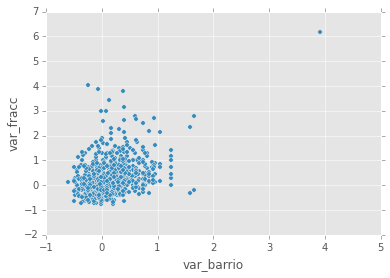

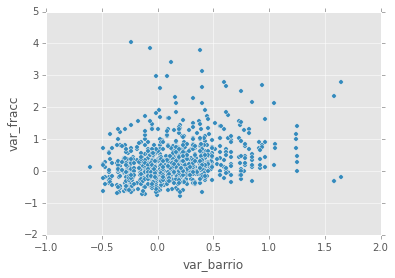

In [16]:
df_vars.plot(kind="scatter", y="var_fracc", x="var_barrio")
df_vars[df_vars["var_barrio"] < 2].plot(kind="scatter", y="var_fracc", x="var_barrio")

No parece haber mucha relación, pero miremos el resultado de una regresión lineal.

In [17]:
from sklearn.linear_model import LinearRegression

Eliminamos los datos con missings.

In [18]:
print len(df_vars), "with nans"
df_vars_clean = df_vars.dropna()
print len(df_vars_clean), "without nans"

983 with nans
974 without nans


Eliminamos los barrios cuyos promedios fueron calculados a partir de muy pocos datos.

In [19]:
def count_fracc_por_barrio(barrio):
    return df_vars_clean[df_vars_clean["BARRIO"] == barrio].sum(level=0).count()["var_fracc"]

def drop_barrios_per_fracc_amout(df, min_fraccs=3):
    for barrio in df["BARRIO"].unique():
        if count_fracc_por_barrio(barrio) < min_fraccs:
            print barrio, count_fracc_por_barrio(barrio)
            df = df[df["BARRIO"] != barrio]
    return df

In [20]:
df_vars_clean = drop_barrios_per_fracc_amout(df_vars_clean, 3)
print len(df_vars_clean), "datos sin barrios con pocas fracciones"

VILLA REAL 2
COGHLAN 2
AGRONOMIA 1
PATERNAL 2
VERSALLES 2
RECOLETA 1
939 datos sin barrios con pocas fracciones


In [21]:
import statsmodels.formula.api as sm

In [22]:
df_model = df_vars_clean[["var_fracc", "var_barrio"]].astype(float)
df_model_filtered = df_model[df_model["var_fracc"] < 2]
res = sm.ols(formula="var_fracc ~ var_barrio", data=df_model).fit()

Un elevado R2 indicaría que la estructura de precios hacia dentro de los barrios es estable, y que la variabilidad del precio promedio por fracciones censales se explica suficientemente bien con el promedio barrial. Esto justificaría el procedimiento de utilizar datos actualizados por promedio barrial de otros años.

In [23]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              var_fracc   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     94.90
Date:                Thu, 03 Dec 2015   Prob (F-statistic):           2.00e-21
Time:                        15:31:15   Log-Likelihood:                -820.14
No. Observations:                 939   AIC:                             1644.
Df Residuals:                     937   BIC:                             1654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1956      0.020      9.647      0.000         0.156     0.235
var_barrio     0.5491      0.056      9.741      0.000         0.438     0.660
==============================================================================
Omnibus:                      435.926   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2971.551
Skew:                           2.009   Prob(JB):                         0.00
Kurtosis:                      10.733   Cond. No.                         3.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Replicamos el modelo para cada barrio, algunos barrios sí podrían tener una estructura de precios más estable.

In [24]:
def modelo_por_barrio(barrio):
    df_model = df_vars_clean[["var_fracc", "var_barrio"]][df_vars_clean["BARRIO"] == barrio].astype(float)
    df_model_filtered = df_model[df_model["var_fracc"] < 2]
    res = sm.ols(formula="var_fracc ~ var_barrio", data=df_model).fit()
    return res.rsquared

In [25]:
barrios_modelados = df_vars_clean["BARRIO"].unique()
serie = pd.Series(index=barrios_modelados, data=map(modelo_por_barrio, barrios_modelados))
serie.sort(ascending=False)
serie

/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


PARQUE CHAS          0.506617
LINIERS              0.459006
SAN NICOLAS          0.419123
BOEDO                0.391193
NUEVA POMPEYA        0.291256
PARQUE PATRICIOS     0.287113
ALMAGRO              0.285084
MONTSERRAT           0.229572
VILLA LURO           0.227159
VILLA LUGANO         0.194361
FLORESTA             0.186218
VILLA DEL PARQUE     0.176667
CONSTITUCION         0.156250
BELGRANO             0.155746
SAN CRISTOBAL        0.144635
MONTE CASTRO         0.131370
PALERMO              0.130665
BOCA                 0.126816
FLORES               0.096775
VELEZ SARSFIELD      0.084632
VILLA PUEYRREDON     0.084418
VILLA SANTA RITA     0.083545
CABALLITO            0.069633
BARRACAS             0.067118
VILLA DEVOTO         0.038985
VILLA URQUIZA        0.036700
MATADEROS            0.034181
SAN TELMO            0.031208
SAAVEDRA             0.022923
PARQUE AVELLANEDA    0.016786
VILLA CRESPO         0.016094
NUÑEZ                0.015871
BALVANERA            0.011102
VILLA GRAL

El procedimiento no parece justificable para la mayoría de los barrios (sino todos), nos quedamos con los datos de 2014. Se calcula el precio del m2 de terreno ofertado promedio para aquellas fracciones con por lo menos 3 datos y donde cada dato no represente más de 200.000 m2 de territorio (unas 20 manzanas).

In [26]:
from scripts import geo_utils

def count_data_fraccs(df_fraccs, df_data, div_name="CO_FRACC", year=2014):
    return df_data[df_data["YEAR"] == year].groupby(div_name)[div_name].count()

def calc_area(df, shp_path):
    for id_shape, shape in geo_utils.iter_shp_as_shapely(shp_path):
        df.loc[id_shape, "area"] = shape.area

In [27]:
remove_scarce_data(fracciones, df, "CO_FRACC", 3)

fracc_2014 = pd.DataFrame(fracciones[2014])
fracc_2014["count_data"] = count_data_fraccs(fracc_2014, df)
calc_area(fracc_2014, get_division_path("fracciones_caba_censo_2010"))
fracc_2014["data_cover"] = fracc_2014["area"] / fracc_2014["count_data"]

fracc_2014[(fracc_2014["data_cover"] > 200000) & (pd.notnull(fracc_2014[2014]))] 

CO_FRACC start with  1434 values
CO_FRACC end with 1434 values 



,2014,count_data,area,data_cover
CO_FRACC,,,,
001_14,2067.437854,3,766949.680521,255649.893507
004_1,508.804259,4,1383155.463525,345788.865881
004_2,910.211435,4,954240.222444,238560.055611
007_21,1622.222222,3,675550.237000,225183.412333
008_14,300.925926,4,2073975.188800,518493.797200
009_1,2032.967033,4,1112971.270910,278242.817727
009_12,757.452575,6,1483265.262792,247210.877132
009_15,767.441860,6,1311813.499059,218635.583176
010_5,998.415214,3,863391.299072,287797.099691


In [28]:
fracc_2014 = fracc_2014[fracc_2014["data_cover"] <= 200000]
fracc_2014.head()

,2014,count_data,area,data_cover
CO_FRACC,,,,
001_10,3346.693387,4,287150.705292,71787.676323
001_12,3924.731183,6,867078.483252,144513.080542
001_15,2213.630042,7,510498.374725,72928.339246
001_16,NaN,2,283086.964844,141543.482422
001_17,1518.361582,4,259548.560455,64887.140114


## Se agrega el indicador construido a la base de datos

Agregamos el dato a los indicadores a nivel de fracción censal.

In [29]:
from scripts.create_indicators import get_or_create_indicators_df

indicators_frac = get_or_create_indicators_df("FRAC", fracc_2014)
old_index = indicators_frac.index.copy()
indicators_frac = indicators_frac.set_index("CO_FRACC")

indicators_frac["terr_14"] = fracc_2014[2014]

fracc_index = indicators_frac.index.copy()
indicators_frac = indicators_frac.set_index(old_index)
indicators_frac["CO_FRACC"] = fracc_index
indicators_frac.to_csv(get_indicators_path("FRAC"), encoding="utf-8")

PyTables is not installed. No support for HDF output.


In [30]:
print "No tienen datos", len(indicators_frac[pd.isnull(indicators_frac["terr_14"])]), "fracciones"
print "Total de fracciones", len(indicators_frac)

No tienen datos 153 fracciones
Total de fracciones 351
